# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
#Defining a model object for the model above, with uncertainty ranges provided. 

from ema_workbench import Model, RealParameter, TimeSeriesOutcome, ScalarOutcome

model = Model('predprey', function=pred_prey)

model.uncertainties = [RealParameter('prey_birth_rate',	0.015, 0.035),
                       RealParameter('predation_rate',0.0005 , 0.003),
                       RealParameter('predator_efficiency',	0.001 , 0.004),
                       RealParameter('predator_loss_rate',	0.04 , 0.08)]

model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]


In [3]:
from ema_workbench import MultiprocessingEvaluator, ema_logging
 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=1000,uncertainty_sampling='lhs')


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# Linear Regression 
### 1. Getting final prey value


In [4]:
### 1. Getting final prey value
i=0
final_prey=[]
for i in range(len(outcomes['prey'])):
    final_prey.append(outcomes['prey'][i][-1][-1])

#gets the final prey values across the 1000 experiments. 
final_prey=list(final_prey)

# Fitting Linear regression model for "Final Prey"
import statsmodels
cleaned = experiments.drop(columns=['scenario','policy','model'])

y= final_prey
x=cleaned

model2= statsmodels.regression.linear_model.OLS(y,x.values)
fitted= model2.fit()
print(list(cleaned.columns))
fitted.params


['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']


array([  2798.81666231, -12927.45048884,    783.48232542,    313.93094766])

### 2. The mean values of the prey outcome over time, within each experiment


In [5]:
### 2. The mean values of the prey outcome over time, within each experiment
i=0
mean_prey=[]
for i in range(len(outcomes['prey'])):
    mean_prey.append(outcomes['prey'][i].mean())

#gets the final prey values across the 1000 experiments. 
mean_prey=list(mean_prey)

# Fitting Linear regression model for "Final Prey"
import statsmodels
cleaned = experiments.drop(columns=['scenario','policy','model'])

y= mean_prey
x=cleaned

model2= statsmodels.regression.linear_model.OLS(y,x.values)
fitted= model2.fit()
print(list(cleaned.columns))
fitted.params


['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']


array([   597.63206401, -11190.25366854,    703.20444136,    441.85019983])

### 3. The standard deviations of the prey outcome over time, within each experiment


In [6]:
### 3. The standard deviations of the prey outcome over time, within each experiment
i=0
std_prey=[]
for i in range(len(outcomes['prey'])):
    std_prey.append(np.std(list(outcomes['prey'][i])))

#gets the final prey values across the 1000 experiments. 
std_prey=list(std_prey)

# Fitting Linear regression model for "Final Prey"
import statsmodels
cleaned = experiments.drop(columns=['scenario','policy','model'])

y= std_prey
x=cleaned

model2= statsmodels.regression.linear_model.OLS(y,x.values)
fitted= model2.fit()
print(list(cleaned.columns))
fitted.params


['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']


array([1863.58951574, 1242.57756519,   83.34687059,  124.22916248])

# Sensitivity Analysis with Sobol

### Creating model. Running with N=50 samples

So, scenarios = N * (2D+2), where D=4 uncertain parameters = 500 scenarios

In [7]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import MultiprocessingEvaluator, ema_logging
 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments_sa, outcomes_sa = evaluator.perform_experiments(scenarios= 500,uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### 1. Sobol indices for N=50, Indicator= Final Prey

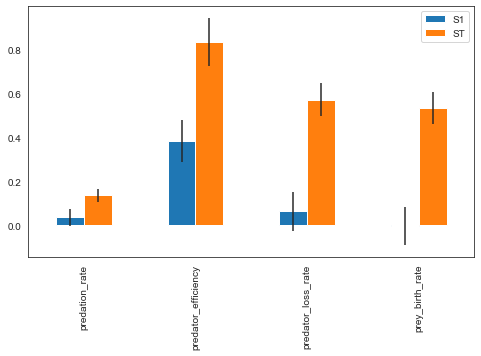

,ST,ST_conf,S1,S1_conf
predation_rate,0.136265,0.031115,0.036162,0.039848
predator_efficiency,0.837965,0.109707,0.383927,0.095808
predator_loss_rate,0.573771,0.077308,0.065012,0.088906
prey_birth_rate,0.535675,0.072544,-0.004517,0.087426


In [10]:
### Getting final prey value
i=0
final_prey_sa=[]
for i in range(len(outcomes_sa['prey'])):
    final_prey_sa.append(outcomes_sa['prey'][i][-1][-1])

#gets the final prey values across the 1000 experiments. 
final_prey_sa=list(final_prey_sa)

# Fitting Linear regression model for "Final Prey"
import statsmodels
cleaned_sa = experiments_sa.drop(columns=['scenario','policy','model'])

y= final_prey_sa
x=cleaned_sa

#########
problem = get_SALib_problem(model.uncertainties)
final_prey_sa=np.array(final_prey_sa)
Si = sobol.analyze(problem, final_prey_sa,
                   calc_second_order=True, print_to_console=False)
 
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()
Si_df

### 2. Sobol indices for N=50, Indicator= Mean of Prey values in every experiment

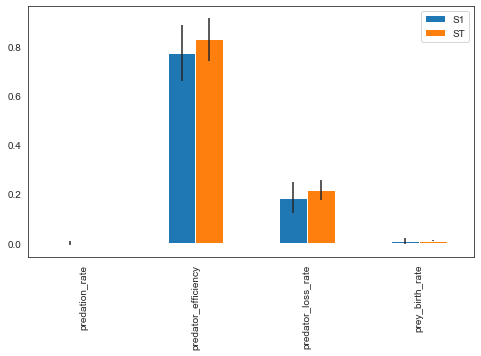

,ST,ST_conf,S1,S1_conf
predation_rate,0.005425,0.001345,0.000661,0.009734
predator_efficiency,0.828010,0.088535,0.773630,0.114236
predator_loss_rate,0.215999,0.040072,0.184630,0.061960
prey_birth_rate,0.010643,0.002047,0.010348,0.012159


In [17]:
i=0
mean_prey_sa=[]
for i in range(len(outcomes_sa['prey'])):
    mean_prey_sa.append(outcomes_sa['prey'][i].mean())

#gets the final prey values across the 1000 experiments. 
mean_prey_sa=list(mean_prey_sa)

# Fitting Linear regression model for "Final Prey"
import statsmodels
cleaned_sa = experiments_sa.drop(columns=['scenario','policy','model'])

y= mean_prey_sa
x=cleaned_sa

problem = get_SALib_problem(model.uncertainties)
mean_prey_sa=np.array(mean_prey_sa)
Si = sobol.analyze(problem, mean_prey_sa,
                   calc_second_order=True, print_to_console=False)
 

sns.set_style('white')
fig, ax = plt.subplots(1)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()
Si_df

### 3. Sobol indices for N=50, Indicator= Standard Deviation of Prey values in every experiment


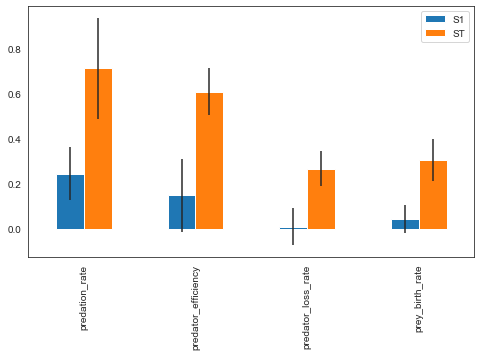

,ST,ST_conf,S1,S1_conf
predation_rate,0.712513,0.225336,0.244450,0.117518
predator_efficiency,0.609725,0.104384,0.148717,0.160736
predator_loss_rate,0.267715,0.077061,0.009356,0.082192
prey_birth_rate,0.306048,0.092411,0.044964,0.063589


In [19]:
i=0
std_prey_sa=[]
for i in range(len(outcomes_sa['prey'])):
    std_prey_sa.append(np.std(list(outcomes_sa['prey'][i])))

#gets the final prey values across the 1000 experiments. 
std_prey_sa=list(std_prey_sa)

x=cleaned_sa
y=std_prey_sa
problem = get_SALib_problem(model.uncertainties)
std_prey_sa=np.array(std_prey_sa)
Si = sobol.analyze(problem, std_prey_sa,
                   calc_second_order=True, print_to_console=False)
 
sns.set_style('white')
fig, ax = plt.subplots(1)

Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=problem['names'])

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()
Si_df


### Running with N=250 samples

So, scenarios = N * (2D+2), where D=4 uncertain parameters = 2500 scenarios

In [22]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import MultiprocessingEvaluator, ema_logging
 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments250, outcomes250 = evaluator.perform_experiments(scenarios= 2500,uncertainty_sampling='sobol')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 25000 scenarios * 1 policies * 1 model(s) = 25000 experiments
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 7500 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] 12500 cases completed
[MainProcess/INFO] 15000 cases completed
[MainProcess/INFO] 17500 cases completed
[MainProcess/INFO] 20000 cases completed
[MainProcess/INFO] 22500 cases completed
[MainProcess/INFO] 25000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


# Sensitivity Analysis with Extra-Trees Random Forrest

In [41]:
#use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?  
from ema_workbench import MultiprocessingEvaluator, ema_logging
 
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    experiments_rf, outcomes_rf = evaluator.perform_experiments(scenarios= 1000,uncertainty_sampling='lhs')


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [43]:
cleaned_rf=experiments_rf.drop(columns=['model','policy'])
from ema_workbench.analysis import get_feature_scores_all
ema_logging.log_to_stderr(level=ema_logging.INFO)

#getting standard deviation across every experiment. 
i=0
std_list=[]
for i in range(len(outcomes_rf['prey'])):
    std_list.append(np.std(outcomes_rf['prey'][i]))

# ET model
x=  cleaned_rf
y = {'mean_prey': np.mean(outcomes_rf['prey'],axis=1),
     'std_prey' : std_list}
#'TIME': outcomes['TIME'][:,-1]
fs = feature_scoring.get_feature_scores_all(
    x,
    y,
    alg='extra trees',
    mode=RuleInductionType.REGRESSION,
    nr_trees=100,
    max_features=0.6,)


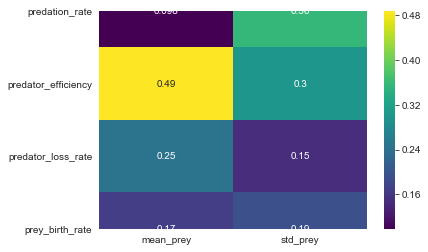

In [44]:
sns.heatmap(fs, annot=True, cmap='viridis')